In [1]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
import os
from skimage import io



# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow_model_optimization.sparsity import keras as sparsity
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style("whitegrid")



In [2]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "wave_combined",
    "fistbump_combined"]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  print(output)
  df = pd.read_csv("/Users/amad/Desktop/Class IMU/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)
# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.4.0

Processing index 0 for gesture 'wave_combined'.
[1. 0.]
	There are 900 recordings of the wave_combined gesture.
Processing index 1 for gesture 'fistbump_combined'.
[0. 1.]
	There are 900 recordings of the fistbump_combined gesture.
Data set parsing and preparation complete.


In [3]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)
# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [4]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dropout(.15))
model.add(tf.keras.layers.Dense(75, activation='relu'))
model.add(tf.keras.layers.Dropout(.15))
model.add(tf.keras.layers.Dense(75, activation='relu'))
model.add(tf.keras.layers.Dropout(.15))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
adam = tf.keras.optimizers.Adam(
       learning_rate=0.0001,
       name="adam")
model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.0001)


In [5]:
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=20,  validation_data=(inputs_validate, outputs_validate))

Epoch 1/100
54/54 [==============================] - 2s 18ms/step - loss: 0.2654 - accuracy: 0.4824 - val_loss: 0.2467 - val_accuracy: 0.6111
Epoch 2/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.5151 - val_loss: 0.2431 - val_accuracy: 0.6389
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.5312 - val_loss: 0.2398 - val_accuracy: 0.6444
Epoch 4/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2418 - accuracy: 0.5682 - val_loss: 0.2368 - val_accuracy: 0.6056
Epoch 5/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2391 - accuracy: 0.5823 - val_loss: 0.2359 - val_accuracy: 0.6111
Epoch 6/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2417 - accuracy: 0.5738 - val_loss: 0.2310 - val_accuracy: 0.6444
Epoch 7/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2312 - accuracy: 0.6411 - val_loss: 0.2240 - val_accuracy: 0.6444
Epoch 8/100


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (20, 100)                 71500     
_________________________________________________________________
dropout (Dropout)            (20, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (20, 75)                  7575      
_________________________________________________________________
dropout_1 (Dropout)          (20, 75)                  0         
_________________________________________________________________
dense_2 (Dense)              (20, 75)                  5700      
_________________________________________________________________
dropout_2 (Dropout)          (20, 75)                  0         
_________________________________________________________________
dense_3 (Dense)              (20, 2)                   1

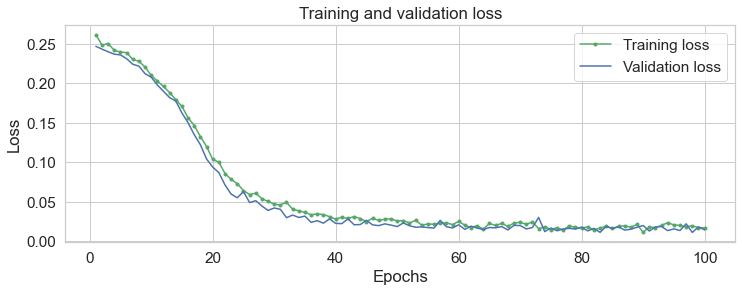

[12.0, 4.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (12,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

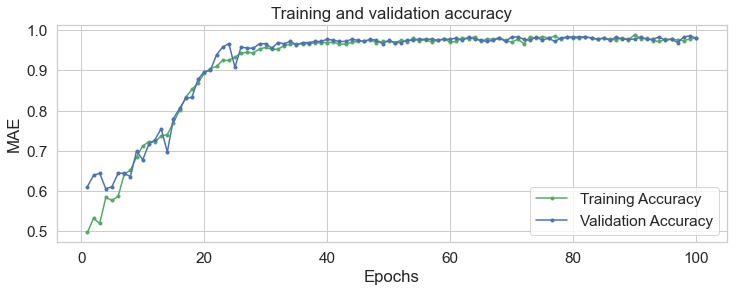

In [8]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [9]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

predictions =
 [[0.019 0.981]
 [0.001 0.999]
 [1.    0.   ]
 [0.573 0.427]
 [0.995 0.005]
 [0.045 0.955]
 [0.021 0.979]
 [0.032 0.968]
 [0.091 0.909]
 [0.008 0.992]
 [0.999 0.001]
 [0.023 0.977]
 [0.005 0.995]
 [0.006 0.994]
 [0.006 0.994]
 [0.029 0.971]
 [0.998 0.002]
 [0.005 0.995]
 [0.02  0.98 ]
 [0.995 0.005]
 [0.749 0.251]
 [0.999 0.001]
 [1.    0.   ]
 [0.999 0.001]
 [0.994 0.006]
 [0.998 0.002]
 [0.03  0.97 ]
 [0.003 0.997]
 [0.998 0.002]
 [0.037 0.963]
 [0.998 0.002]
 [1.    0.   ]
 [0.991 0.009]
 [0.999 0.001]
 [0.023 0.977]
 [0.034 0.966]
 [0.002 0.998]
 [0.994 0.006]
 [0.998 0.002]
 [0.868 0.132]
 [0.996 0.004]
 [0.005 0.995]
 [0.023 0.977]
 [0.996 0.004]
 [0.022 0.978]
 [0.036 0.964]
 [0.887 0.113]
 [0.01  0.99 ]
 [0.996 0.004]
 [0.999 0.001]
 [1.    0.   ]
 [0.036 0.964]
 [0.031 0.969]
 [1.    0.   ]
 [0.999 0.001]
 [0.998 0.002]
 [1.    0.   ]
 [0.012 0.988]
 [0.018 0.982]
 [0.015 0.985]
 [0.995 0.005]
 [0.005 0.995]
 [0.998 0.002]
 [0.006 0.994]
 [0.997 0.003]
 [1.    0.

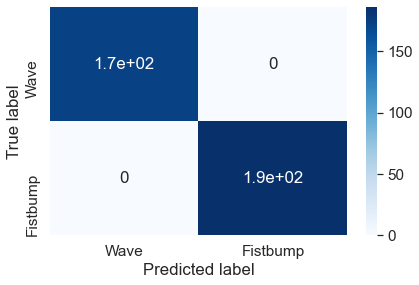

In [10]:
cm = tf.math.confusion_matrix(labels=tf.argmax(outputs_test, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ["Wave", "Fistbump"]
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Conversion of model to tensorflow lite model


In [11]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("models/gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("models/gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /var/folders/6x/f_7qfg9s71jbzpkygx9sw7s40000gn/T/tmpuhvx7mrx/assets
Model is 341768 bytes


# Creating Model Header File


In [12]:
!echo "const unsigned char model[] = {" > models/model.h
!cat models/gesture_model.tflite | xxd -i      >> models/model.h
!echo "};"                              >> models/model.h

import os
model_h_size = os.path.getsize("models/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 2,107,604 bytes.


# Pruning the model


In [14]:
# Compute end step to finish pruning after 450 epochs.
epochs = 50
end_step = np.ceil(1.0 * TRAIN_SPLIT / 10).astype(np.int32) * epochs
print(end_step)

# Define model for pruning by starting the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity.
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.65,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

# `prune_low_magnitude` requires a recompile
model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)
model_for_pruning.summary()
adam = tf.keras.optimizers.Adam(
       learning_rate=0.0001,
       name="adam")
model_for_pruning.compile(
    loss=["mse"],
    optimizer= "adam",
    metrics=['accuracy'])


5400
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense (P (None, 100)               142902    
_________________________________________________________________
prune_low_magnitude_dropout  (None, 100)               1         
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 75)                15077     
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 75)                1         
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 75)                11327     
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 75)                1         
_________________________________________________________________
prune_low_magnitude_dense_3  (None, 2)             

# Fit the pruning model


In [15]:
import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.0001)

]
his = model_for_pruning.fit(inputs_train, outputs_train,
          batch_size=10,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=(inputs_validate, outputs_validate))

score = model_for_pruning.evaluate(inputs_validate, outputs_validate, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
  2/108 [..............................] - ETA: 8s - loss: 0.0529 - accuracy: 0.9250  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0133s). Check your callbacks.


108/108 [==============================] - 4s 5ms/step - loss: 0.3977 - accuracy: 0.5832 - val_loss: 0.4889 - val_accuracy: 0.5111
Epoch 2/50
108/108 [==============================] - 0s 2ms/step - loss: 0.4925 - accuracy: 0.5075 - val_loss: 0.4889 - val_accuracy: 0.5111
Epoch 3/50
108/108 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.5046 - val_loss: 0.1989 - val_accuracy: 0.6583
Epoch 4/50
108/108 [==============================] - 0s 3ms/step - loss: 0.3040 - accuracy: 0.6012 - val_loss: 0.2289 - val_accuracy: 0.5694
Epoch 5/50
108/108 [==============================] - 0s 3ms/step - loss: 0.2165 - accuracy: 0.6295 - val_loss: 0.1661 - val_accuracy: 0.8278
Epoch 6/50
108/108 [==============================] - 0s 2ms/step - loss: 0.1649 - accuracy: 0.7668 - val_loss: 0.1241 - val_accuracy: 0.9000
Epoch 7/50
108/108 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.8405 - val_loss: 0.1131 - val_accuracy: 0.8611
Epoch 8/50
108/10

In [16]:
pruned_model = sparsity.strip_pruning(model_for_pruning)
pruned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               71500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                5700      
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1

# Confusion matrix of pruned model


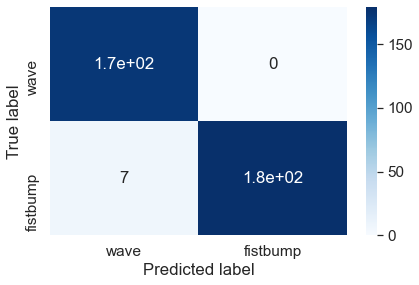

In [18]:
predictions_p = pruned_model.predict(inputs_test)
cm = tf.math.confusion_matrix(labels=tf.argmax(outputs_test, 1), predictions=tf.argmax(predictions_p, 1))
axis_labels = ["wave", "fistbump"]
figure = plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.tight_layout()
plt.ylim(len(cm)-0, 0)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Weights of pruned model


In [19]:
from tensorflow.keras.models import load_model
import numpy as np

for i, w in enumerate(pruned_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            pruned_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )


dense/kernel:0 -- Total:71400, Zeros: 90.00%
dense/bias:0 -- Total:100, Zeros: 13.00%
dense_1/kernel:0 -- Total:7500, Zeros: 90.00%
dense_1/bias:0 -- Total:75, Zeros: 0.00%
dense_2/kernel:0 -- Total:5625, Zeros: 89.99%
dense_2/bias:0 -- Total:75, Zeros: 0.00%
dense_3/kernel:0 -- Total:150, Zeros: 90.00%
dense_3/bias:0 -- Total:2, Zeros: 0.00%


# Converting pruned model to tflite model


In [20]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
tflite_pruned_model = converter.convert()

# Save the model to disk
open("models/gesture_pruned_model.tflite", "wb").write(tflite_pruned_model)
  
import os
basic_model_size = os.path.getsize("models/gesture_pruned_model.tflite")
print("gesture_pruned_model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /var/folders/6x/f_7qfg9s71jbzpkygx9sw7s40000gn/T/tmph0_ywqcv/assets


INFO:tensorflow:Assets written to: /var/folders/6x/f_7qfg9s71jbzpkygx9sw7s40000gn/T/tmph0_ywqcv/assets


gesture_pruned_model is 341884 bytes


# Creating Pruned Model Header File


In [21]:
!echo "const unsigned char model[] = {" > models/pruned_model.h
!cat models/gesture_pruned_model.tflite | xxd -i      >> models/pruned_model.h
!echo "};"                              >> models/pruned_model.h

import os
model_h_size = os.path.getsize("models/pruned_model.h")
print(f"Header file, pruned_model.h, is {model_h_size:,} bytes.")

Header file, pruned_model.h, is 2,108,320 bytes.


# Quantization of pruned model


In [22]:
# To measure the dynamic range of activations and inputs by supplying sample input data to the converter
def representative_data_gen():
  for input_value in np.array(inputs_train, dtype=np.float32):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Reduce the size of a floating point model by quantizing the weights
converter.representative_dataset = representative_data_gen

pruned_quantized_tflite_model = converter.convert()

# Save the model to disk
open("models/pruned_quantized_model.tflite", "wb").write(pruned_quantized_tflite_model)

import os
basic_model_size = os.path.getsize("models/pruned_quantized_model.tflite")
print("pruned_quantized_model is %d bytes" % basic_model_size)


INFO:tensorflow:Assets written to: /var/folders/6x/f_7qfg9s71jbzpkygx9sw7s40000gn/T/tmpvpib_iz_/assets


INFO:tensorflow:Assets written to: /var/folders/6x/f_7qfg9s71jbzpkygx9sw7s40000gn/T/tmpvpib_iz_/assets


pruned_quantized_model is 89040 bytes


# Creating Quantized Model Header File


In [23]:
!echo "const unsigned char model[] = {" > models/pruned_quantized_model.h
!cat models/pruned_quantized_model.tflite | xxd -i      >> models/pruned_quantized_model.h
!echo "};"                              >> models/pruned_quantized_model.h

import os
pruned_quantized_model_h_size = os.path.getsize("models/pruned_quantized_model.h")
print(f"Header file, pruned_quantized_model.h, is {pruned_quantized_model_h_size:,} bytes.")


Header file, pruned_quantized_model.h, is 549,114 bytes.


# Evaluating the Quantized Model


In [25]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  arr = []
  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(inputs_test):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    # print(test_image)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)

  for i in range(0,len(outputs_test)):
    arr.append(np.argmax(outputs_test[i]))
  accuracy = (prediction_digits == np.array(arr)).mean()
  return accuracy

In [26]:
interpreter = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

Pruned and quantized TFLite test_accuracy: 0.9777777777777777


In [27]:
# Pruned model accuracy
interpreter1 = tf.lite.Interpreter(model_content=tflite_pruned_model)
interpreter1.allocate_tensors()

test_accuracy_ = evaluate_model(interpreter1)
print('Pruned TF test accuracy:', test_accuracy_)

Pruned TF test accuracy: 0.9805555555555555
